# 🌀 RealNVP

In this notebook, we'll walk through the steps required to train your own RealNVP network to predict the distribution of a demo dataset

The code has been adapted from the excellent [RealNVP tutorial](https://keras.io/examples/generative/pixelcnn/) created by Mandolini Giorgio Maria, Sanna Daniele and Zannini Quirini Giorgio available on the Keras website.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    regularizers,
    metrics,
    optimizers,
    callbacks,
)

%cd /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks

import tensorflow_probability as tfp

2023-07-28 10:13:31.060841: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-28 10:13:31.086196: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-28 10:13:31.087170: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 10:13:31.682051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks


## 0. Parameters <a name="parameters"></a>

In [3]:
COUPLING_DIM = 256
COUPLING_LAYERS = 2
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 300

2023-07-28 10:13:32.871645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-28 10:13:32.872201: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


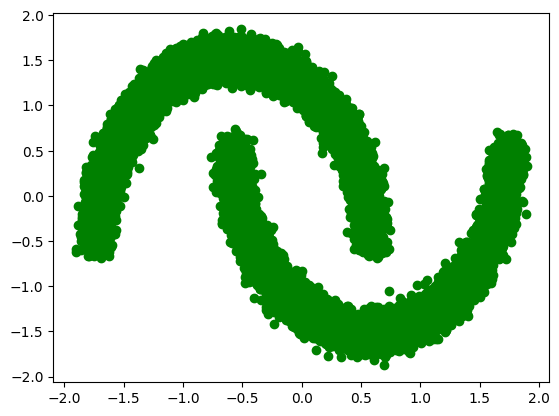

In [4]:
# Load the data
data = datasets.make_moons(30000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)
plt.scatter(
    normalized_data.numpy()[:, 0], normalized_data.numpy()[:, 1], c="green"
)
plt.show()

## 2. Build the RealNVP network <a name="build"></a>

## Mathematical Overview

To begin, we will talk about the overarching model architecture, the *Normalizing Flow* (NF). Recall that in an autoregressive model, we sought to lean some simpler distribution $q(\mathbf{z}|\mathbf{x})$ in the encoder and then train a decoder to take that simple distribution and recreate our original point, $\hat{\mathbf{x}} \sim p(\mathbf{x}|\mathbf{z}) \approx \mathbf{x}$

In the NF model, however, the decoding function is going to be the exact inverse of the encoding function. There is an immediate problem, namely that neural networks are not invertible. So, how do we make use of deep learning while creating an invertible process between a complex distribution and a simpler one (like a Gaussian)?

To do so, we will describe first a *Change of Variables* for probability distributions. Let $X$ be a random variable related by some mapping $f: \mathbb{R}^n \rightarrow \mathbb{R}^n$ such that $X=f(Z)$ and $Z=f^{-1}(X)$. Then:

$$ p_X (\mathbf{x}) = p_Z (\mathbf{z}) \left| \det \left( \frac{\partial \mathbf{z}}{\partial \mathbf{x} } \right) \right| = p_Z (f^{-1}(\mathbf{x})) \left| \det \left( \frac{\partial f^{-1}(\mathbf{x})}{\partial \mathbf{x} } \right) \right| $$

In the above, $det(A)# is the *Determinant* of sqaure matrices $A$. 

The partial derivative is known as the *Jacobian*:

$$ J = \frac{\partial f^{-1}(\mathbf{x})}{\partial \mathbf{x} } = \frac{\partial \mathbf{z}}{\partial \mathbf{x} } $$

Now then, $J$ is an $n \times n$ matrix where each entry $(i,j) =\frac{\partial f^{-1}(\mathbf{x})_i}{\partial \mathbf{x}_j }$, or the partial derivative of the $ith$ component of $\mathbf{z} = f^{-1}(\mathbf{x})$ by the $jth$ component of $\mathbf{x}$

Luckily, for invertible martices $A$, $det(A^{-1}) = det(A)^{-1}$. This allows us to write our above formulation as:

$$ p_X (\mathbf{x}) = p_Z (\mathbf{z}) \left| \det \left( \frac{\partial \mathbf{z}}{\partial \mathbf{x} } \right) \right| = p_Z (f^{-1}(\mathbf{x})) \left| \det \left( \frac{\partial f(\mathbf{x})}{\partial \mathbf{x} } \right) \right|^{-1} $$

Because we are using a neural network with weights $\theta$, we can write our function as $X=f_{\theta}(Z)$ and $Z=f_{\theta}^{-1}(X)$, giving us:

$$ p_X (\mathbf{x}) = p_Z (\mathbf{z}) \left| \det \left( \frac{\partial \mathbf{z}}{\partial \mathbf{x} } \right) \right| = p_Z (f_{\theta}^{-1}(\mathbf{x})) \left| \det \left( \frac{\partial f_{\theta}^{-1}(\mathbf{x})}{\partial \mathbf{x} } \right) \right| $$

In this notebook, we are using the *Real Non-Volume Preserving* (RealNVP) model. A *Volume-Preserving* mapping is one in which $\left| \det \left( \frac{\partial \mathbf{z}}{\partial \mathbf{x} } \right) \right|=1$.

In it, the data $\mathbf{x}$ is divided into two distinct subsets, $\mathbf{x}_{1:d}$ and $\mathbf{x}_{d+1:D}$. It then has two transformations as part of the mapping, the *scaling* $s$ and the *translation* $t$. Now, in the transformation, the first part is simply passed through and only the second is transformed. This gives us:

$$ \mathbf{z}_{1:d} = \mathbf{x}_{1:d} $$
$$ \mathbf{z}_{d+1:D} = \mathbf{x}_{d+1:D} \odot \exp(s_{\theta}(\mathbf{x}_{1:d})) + t_{\theta}(\mathbf{x}_{1:d}) $$

The inverse is then:

$$ \mathbf{x}_{1:d} = \mathbf{z}_{1:d} $$
$$ \mathbf{x}_{d+1:D} = (\mathbf{z}_{d+1:D} - t_{\theta}(\mathbf{z}_{1:d})) \odot \exp(-s_{\theta}(\mathbf{z}_{1:d})) $$

We do this specifically for the Jacobian:

$$ J = \left| \begin{matrix}
\mathbf{I}_d & 0\\
\frac{\partial \mathbf{z}_{d+1:D}}{\partial \mathbf{x}_{1:d}} & diag(\exp[s_{\theta}(\mathbf{x}_{1:d})])
\end{matrix} \right| $$

Now, because this is a *Lower Triangular Matrix*, the determinant is just the product of the elements of the diagonal. So, multiplying a bunch of exponentials gives us:

$$ \det(J) = \exp \left[ \sum_j s_{\theta}(\mathbf{x}_1:d)_j \right] $$

We thus have both of our criteria met, that $\det(J)$ be easily computable and that our mapping be invertible. 

Now, we will use *Coupling* layers, simple dense neural network layers who ouput our $s$ and $t$. So, our model looks like:

<div style='text-align: center;'>
    <img src='/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/Graphics/RealNVP.png' alt='RealNVP' width='500'>
</div>

However, how do we get $\mathbf{z}_{1:d}$? Well, we just stack the coupling layers and alternate the masking! So, $\mathbf{x}_{1:d}$ is passed through to become $\mathbf{y}_{1:d}$ and $\mathbf{x}_{d+1:D}$ is manipulated to become $\mathbf{y}_{d+1:D}$. In the next layer, $\mathbf{y}_{d+1:D}$ is passed through to become $\mathbf{q}_{d+1:D}$ while $\mathbf{y}_{1:d}$ is manipulated to become $\mathbf{q}_{1:d}$, and so on.

Finally, our loss function is:

$$ \mathcal{L}(\mathbf{x}) = -\log(p_X(\mathbf{x})) = - \log(p_Z(\mathbf{z})) - \log \left( \left| \det \left( \frac{\partial \mathbf{z}}{\partial \mathbf{x}} \right) \right| \right) $$

However, recall that $\det(J) = \exp \left[ \sum_j s_{\theta}(\mathbf{x}_1:d)_j \right]$, so when we do $- \log$ of this, the $exp$ is gone, giving us just negative times the sum of the scaling factors.

We are choosing $Z = \mathcal{N}(0,\mathbf{1})$

This notes page is a good resource: https://deepgenerativemodels.github.io/notes/flow/

In [5]:
def Coupling(input_dim, coupling_dim, reg):
    input_layer = layers.Input(shape=input_dim)
    # Scaling
    s_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    s_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = layers.Dense(
        input_dim, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)
    # Translation
    t_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    t_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = layers.Dense(
        input_dim, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    return models.Model(inputs=input_layer, outputs=[s_layer_5, t_layer_5]) # Outputs the scaling and translation

In [26]:
class RealNVP(models.Model):
    def __init__(
        self, input_dim, coupling_layers, coupling_dim, regularization
    ):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        ) # We are choosing to map the X onto Z as a normal Gaussian
        self.masks = np.array(
            [[0, 1], [1, 0]] * (coupling_layers // 2), dtype="float32"
        ) # We are using the Moons dataset, so each x is only a vector of length two. So, our masks will alteratively mask out one of the two points
        self.loss_tracker = metrics.Mean(name="loss")
        self.layers_list = [
            Coupling(input_dim, coupling_dim, regularization)
            for i in range(coupling_layers)
        ]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i] # Turns off half
            reversed_mask = 1 - self.masks[i] # Reverses the mask
            s, t = self.layers_list[i](x_masked) # We now have s and t
            s *= reversed_mask # Gives us now [0,s/t] or [s/t,0], opposite of the mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            ) # Calculates our output which is modular to the direction and gate (as in, one function that can do both)
            log_det_inv += gate * tf.reduce_sum(s, axis=1) # If direction = 1, then (1-1)/2 is 0, and so this whole thing is 0. Only when direction=-1
            # then the gate=-1, meaning we can calculate the negative determinate, which, recall, is the sum of s.
        return x, log_det_inv

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet # Note here that we don't need the negative in front of the log_prob(y), as it is
        # giving it to us in negative form already
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


model = RealNVP(
    input_dim=INPUT_DIM,
    coupling_layers=COUPLING_LAYERS,
    coupling_dim=COUPLING_DIM,
    regularization=REGULARIZATION,
)

'\nIssue! log_det_inv += gate * tf.reduce_sum(s, axis=1) is missing the absolute value (pg 181) and log_likelihood = self.distribution.log_prob(y) + logdet\nseems like it should have a negative in front of self.distribution.log_prob(y). What gives?\n'

In [27]:
# Example of a mask with four coupling layers

np.array(
            [[0, 1], [1, 0]] * (4 // 2), dtype="float32"
        )

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

## 3. Train the RealNVP network <a name="train"></a>

In [28]:
# Compile and train the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001))

In [29]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def generate(self):
        # From data to latent space.
        z, _ = model(normalized_data)

        # From latent space to data.
        samples = model.distribution.sample(self.num_samples)
        x, _ = model.predict(samples, verbose=0) # Turns training off, so we feed this a sample from our normal distribution and it spits out x values

        return x, z, samples

    def display(self, x, z, samples, save_to=None):
        f, axes = plt.subplots(2, 2)
        f.set_size_inches(8, 5)

        axes[0, 0].scatter(
            normalized_data[:, 0], normalized_data[:, 1], color="r", s=1
        )
        axes[0, 0].set(title="Data space X", xlabel="x_1", ylabel="x_2")
        axes[0, 0].set_xlim([-2, 2])
        axes[0, 0].set_ylim([-2, 2])
        axes[0, 1].scatter(z[:, 0], z[:, 1], color="r", s=1)
        axes[0, 1].set(title="f(X)", xlabel="z_1", ylabel="z_2")
        axes[0, 1].set_xlim([-2, 2])
        axes[0, 1].set_ylim([-2, 2])
        axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g", s=1)
        axes[1, 0].set(title="Latent space Z", xlabel="z_1", ylabel="z_2")
        axes[1, 0].set_xlim([-2, 2])
        axes[1, 0].set_ylim([-2, 2])
        axes[1, 1].scatter(x[:, 0], x[:, 1], color="g", s=1)
        axes[1, 1].set(title="g(Z)", xlabel="x_1", ylabel="x_2")
        axes[1, 1].set_xlim([-2, 2])
        axes[1, 1].set_ylim([-2, 2])

        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        if save_to:
            plt.savefig(save_to)
            print(f"\nSaved to {save_to}")

        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            x, z, samples = self.generate()
            self.display(
                x,
                z,
                samples,
                save_to="/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_normflow/01_realnvp/output/generated_img_%03d.png" % (epoch),
            )


img_generator_callback = ImageGenerator(num_samples=3000)

Epoch 1/300
111/118 [===========================>..] - ETA: 0s - loss: 2.5707
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_normflow/01_realnvp/output/generated_img_000.png


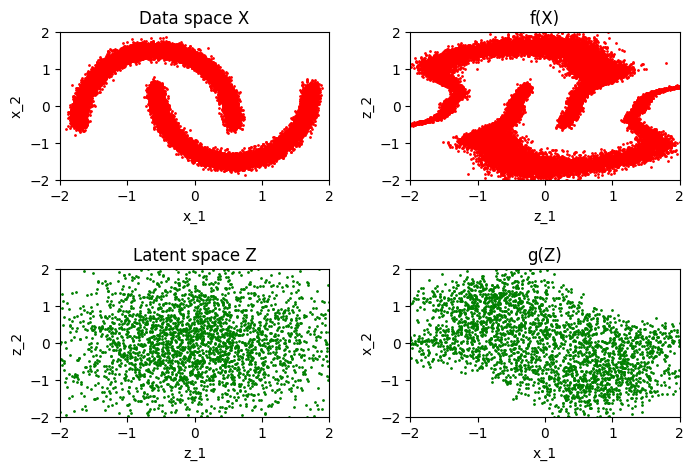

118/118 [==============================] - 3s 12ms/step - loss: 2.5612
Epoch 2/300
118/118 [==============================] - 1s 5ms/step - loss: 2.3324
Epoch 3/300
118/118 [==============================] - 1s 5ms/step - loss: 2.1684
Epoch 4/300
118/118 [==============================] - 1s 5ms/step - loss: 2.0671
Epoch 5/300
118/118 [==============================] - 1s 5ms/step - loss: 2.0036
Epoch 6/300
118/118 [==============================] - 1s 5ms/step - loss: 1.9465
Epoch 7/300
118/118 [==============================] - 1s 5ms/step - loss: 1.8600
Epoch 8/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7787
Epoch 9/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7670
Epoch 10/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7544
Epoch 11/300
112/118 [===========================>..] - ETA: 0s - loss: 1.7543
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_normflow/01_realnv

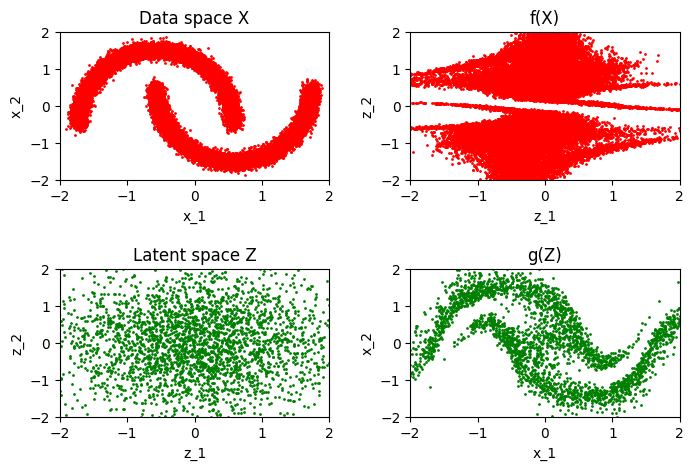

118/118 [==============================] - 1s 12ms/step - loss: 1.7541
Epoch 12/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7476
Epoch 13/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7455
Epoch 14/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7423
Epoch 15/300
118/118 [==============================] - 1s 6ms/step - loss: 1.7402
Epoch 16/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7321
Epoch 17/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7427
Epoch 18/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7357
Epoch 19/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7370
Epoch 20/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7303
Epoch 21/300
114/118 [===========================>..] - ETA: 0s - loss: 1.7357
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_normflow/0

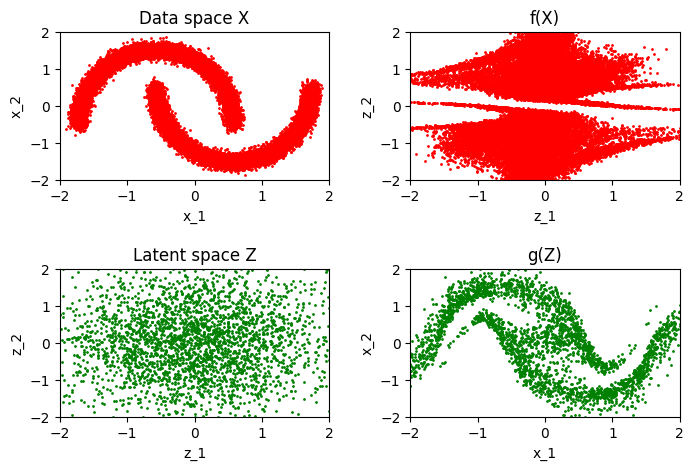

118/118 [==============================] - 1s 11ms/step - loss: 1.7349
Epoch 22/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7273
Epoch 23/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7325
Epoch 24/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7269
Epoch 25/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7326
Epoch 26/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7247
Epoch 27/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7320
Epoch 28/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7268
Epoch 29/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7274
Epoch 30/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7213
Epoch 31/300
115/118 [============================>.] - ETA: 0s - loss: 1.7272
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_normflow/0

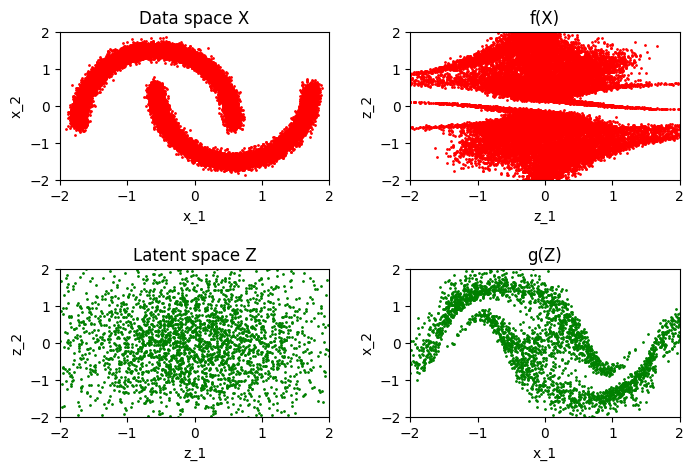

118/118 [==============================] - 1s 11ms/step - loss: 1.7281
Epoch 32/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7297
Epoch 33/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7284
Epoch 34/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7239
Epoch 35/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7210
Epoch 36/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7274
Epoch 37/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7264
Epoch 38/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7244
Epoch 39/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7203
Epoch 40/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7246
Epoch 41/300
116/118 [============================>.] - ETA: 0s - loss: 1.7221
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_normflow/0

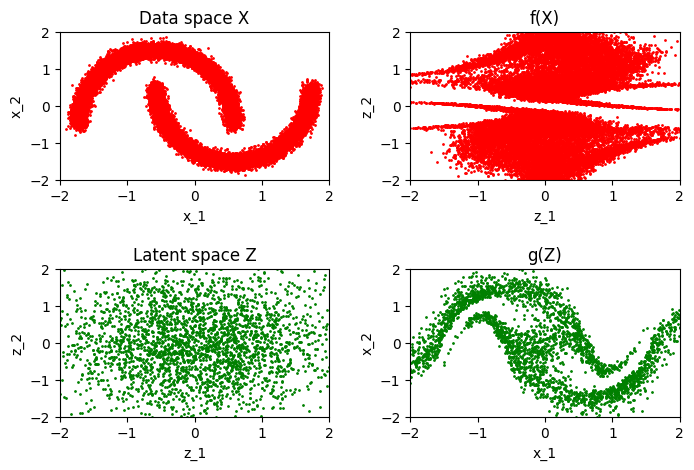

118/118 [==============================] - 1s 11ms/step - loss: 1.7226
Epoch 42/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7225
Epoch 43/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7255
Epoch 44/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7211
Epoch 45/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7212
Epoch 46/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7267
Epoch 47/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7190
Epoch 48/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7200
Epoch 49/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7211
Epoch 50/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7232
Epoch 51/300
116/118 [============================>.] - ETA: 0s - loss: 1.7168
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_normflow/0

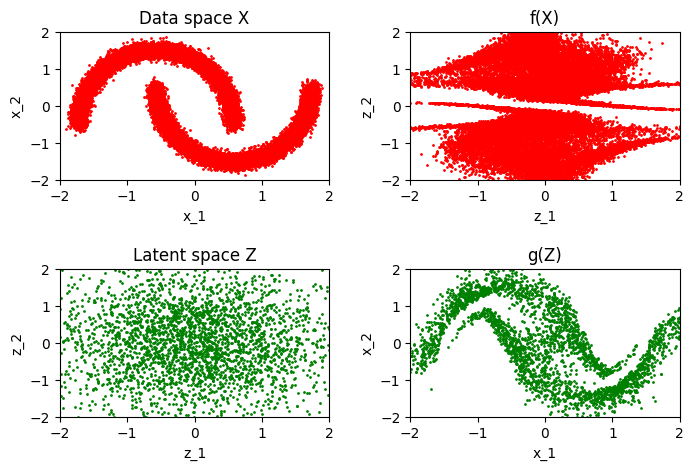

118/118 [==============================] - 1s 11ms/step - loss: 1.7179
Epoch 52/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7209
Epoch 53/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7240
Epoch 54/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7191
Epoch 55/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7302
Epoch 56/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7278
Epoch 57/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7166
Epoch 58/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7177
Epoch 59/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7194
Epoch 60/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7202
Epoch 61/300
117/118 [============================>.] - ETA: 0s - loss: 1.7225
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_normflow/0

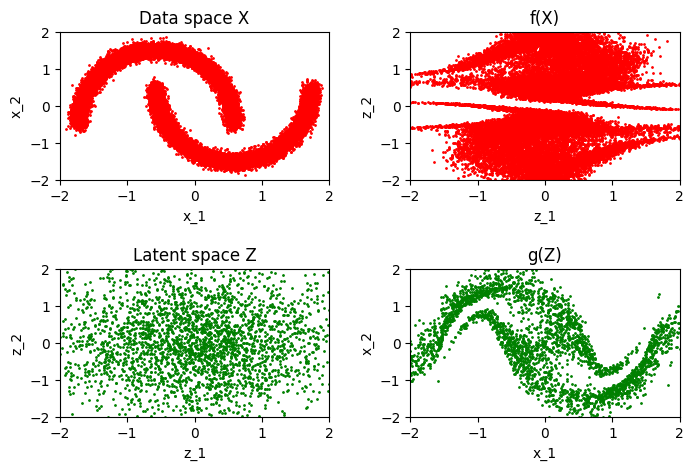

118/118 [==============================] - 1s 11ms/step - loss: 1.7238
Epoch 62/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7211
Epoch 63/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7187
Epoch 64/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7206
Epoch 65/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7197
Epoch 66/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7171
Epoch 67/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7218
Epoch 68/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7227
Epoch 69/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7154
Epoch 70/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7168
Epoch 71/300
112/118 [===========================>..] - ETA: 0s - loss: 1.7125
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_normflow/0

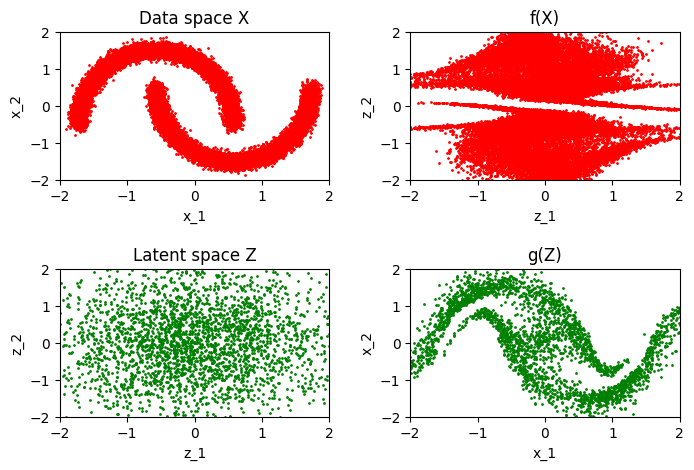

118/118 [==============================] - 1s 11ms/step - loss: 1.7128
Epoch 72/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7158
Epoch 73/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7154
Epoch 74/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7159
Epoch 75/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7217
Epoch 76/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7207
Epoch 77/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7219
Epoch 78/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7153
Epoch 79/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7154
Epoch 80/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7179
Epoch 81/300
117/118 [============================>.] - ETA: 0s - loss: 1.7215
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_normflow/0

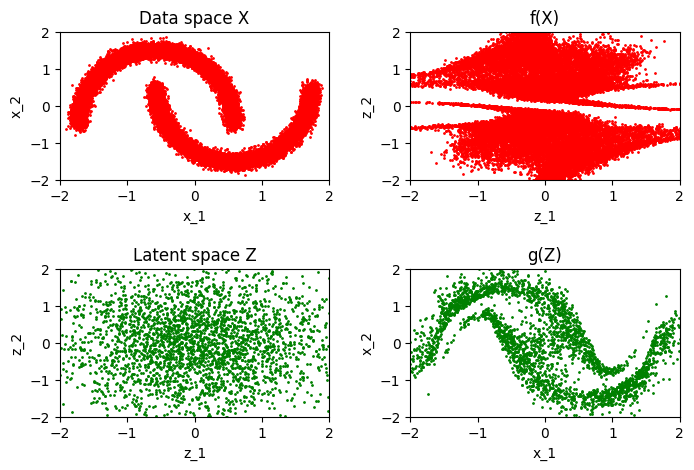

118/118 [==============================] - 1s 11ms/step - loss: 1.7210
Epoch 82/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7160
Epoch 83/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7173
Epoch 84/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7172
Epoch 85/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7130
Epoch 86/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7187
Epoch 87/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7219
Epoch 88/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7220
Epoch 89/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7194
Epoch 90/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7203
Epoch 91/300
116/118 [============================>.] - ETA: 0s - loss: 1.7163
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_normflow/0

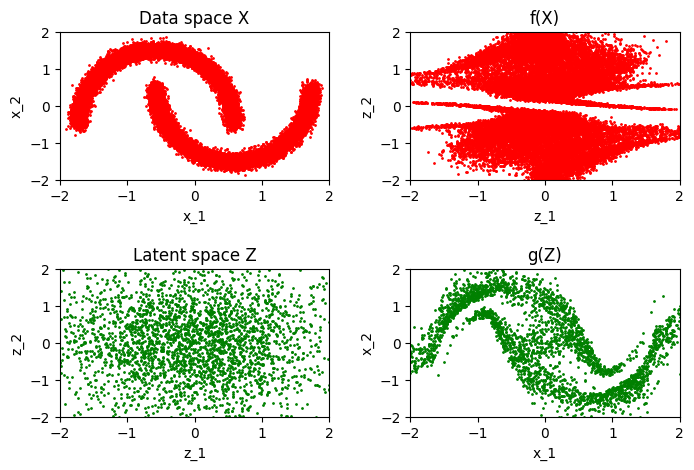

118/118 [==============================] - 1s 11ms/step - loss: 1.7153
Epoch 92/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7109
Epoch 93/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7181
Epoch 94/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7195
Epoch 95/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7233
Epoch 96/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7165
Epoch 97/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7158
Epoch 98/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7129
Epoch 99/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7183
Epoch 100/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7207
Epoch 101/300
117/118 [============================>.] - ETA: 0s - loss: 1.7139
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_normflow

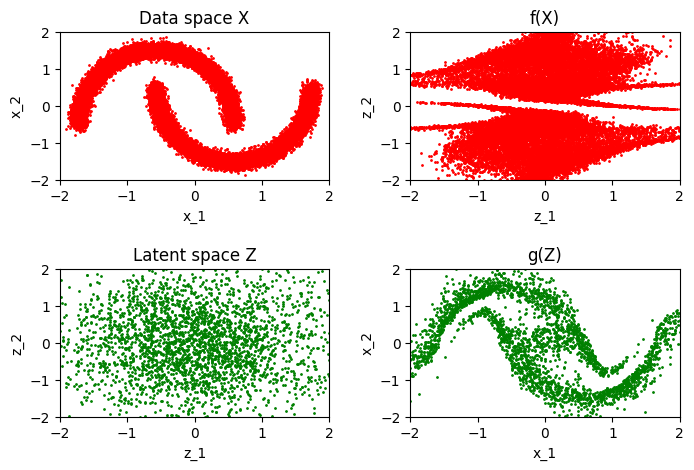

118/118 [==============================] - 1s 11ms/step - loss: 1.7140
Epoch 102/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7152
Epoch 103/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7548
Epoch 104/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7164
Epoch 105/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7151
Epoch 106/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7158
Epoch 107/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7167
Epoch 108/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7122
Epoch 109/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7195
Epoch 110/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7138
Epoch 111/300
117/118 [============================>.] - ETA: 0s - loss: 1.7198
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

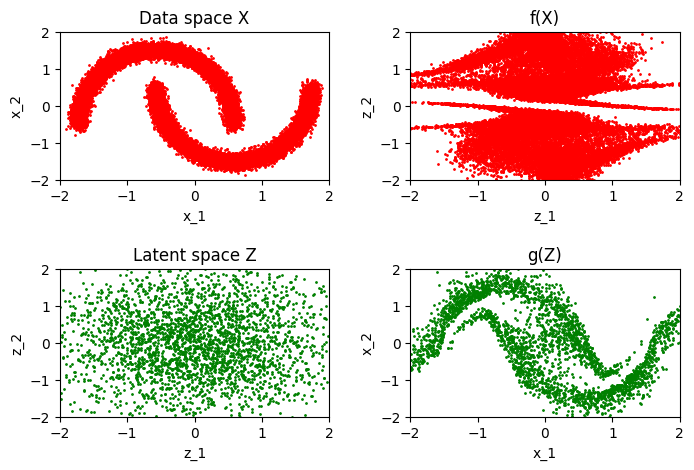

118/118 [==============================] - 2s 13ms/step - loss: 1.7205
Epoch 112/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7116
Epoch 113/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7143
Epoch 114/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7208
Epoch 115/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7171
Epoch 116/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7186
Epoch 117/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7081
Epoch 118/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7140
Epoch 119/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7148
Epoch 120/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7208
Epoch 121/300
112/118 [===========================>..] - ETA: 0s - loss: 1.7115
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

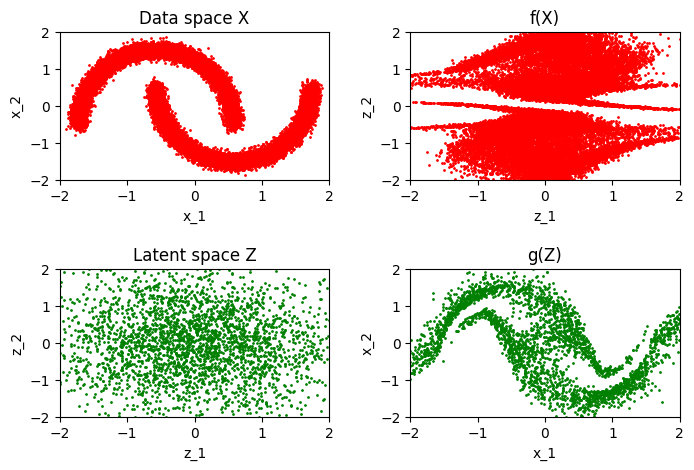

118/118 [==============================] - 1s 11ms/step - loss: 1.7113
Epoch 122/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7211
Epoch 123/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7182
Epoch 124/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7180
Epoch 125/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7153
Epoch 126/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7215
Epoch 127/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7150
Epoch 128/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7105
Epoch 129/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7099
Epoch 130/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7141
Epoch 131/300
115/118 [============================>.] - ETA: 0s - loss: 1.7208
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

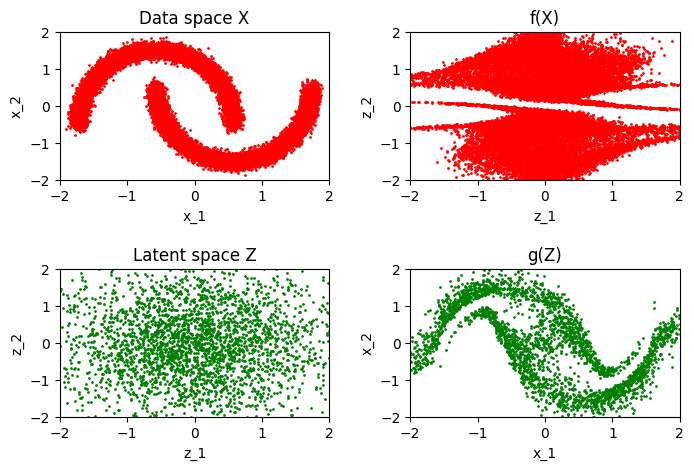

118/118 [==============================] - 1s 11ms/step - loss: 1.7220
Epoch 132/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7083
Epoch 133/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7141
Epoch 134/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7118
Epoch 135/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7152
Epoch 136/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7130
Epoch 137/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7126
Epoch 138/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7092
Epoch 139/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7101
Epoch 140/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7126
Epoch 141/300
112/118 [===========================>..] - ETA: 0s - loss: 1.7180
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

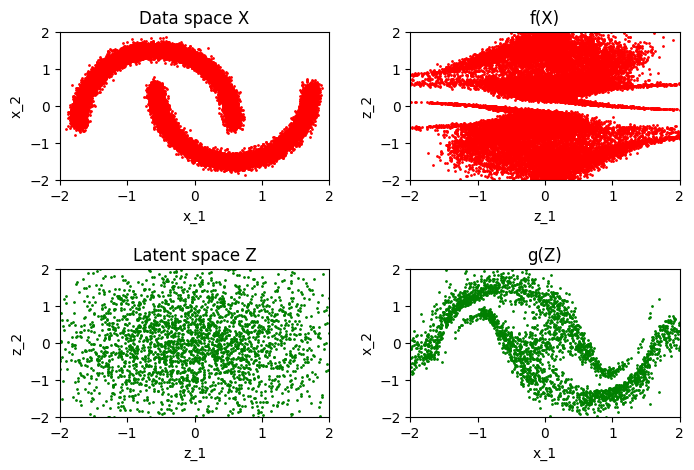

118/118 [==============================] - 1s 11ms/step - loss: 1.7184
Epoch 142/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7179
Epoch 143/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7173
Epoch 144/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7104
Epoch 145/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7098
Epoch 146/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7103
Epoch 147/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7092
Epoch 148/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7149
Epoch 149/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7194
Epoch 150/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7142
Epoch 151/300
115/118 [============================>.] - ETA: 0s - loss: 1.7150
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

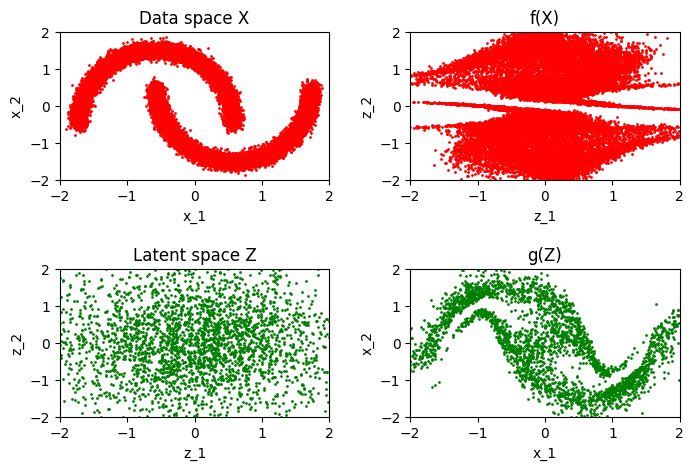

118/118 [==============================] - 1s 11ms/step - loss: 1.7145
Epoch 152/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7139
Epoch 153/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7126
Epoch 154/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7261
Epoch 155/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7124
Epoch 156/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7098
Epoch 157/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7107
Epoch 158/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7177
Epoch 159/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7220
Epoch 160/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7087
Epoch 161/300
112/118 [===========================>..] - ETA: 0s - loss: 1.7106
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

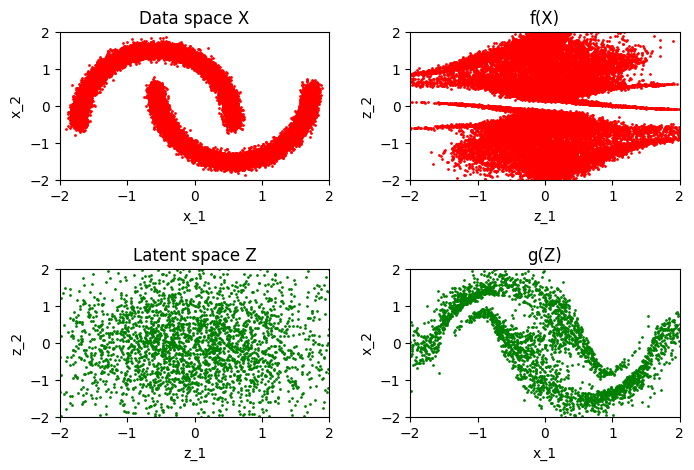

118/118 [==============================] - 1s 11ms/step - loss: 1.7118
Epoch 162/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7206
Epoch 163/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7065
Epoch 164/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7174
Epoch 165/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7100
Epoch 166/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7117
Epoch 167/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7118
Epoch 168/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7136
Epoch 169/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7077
Epoch 170/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7113
Epoch 171/300
108/118 [==========================>...] - ETA: 0s - loss: 1.7091
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

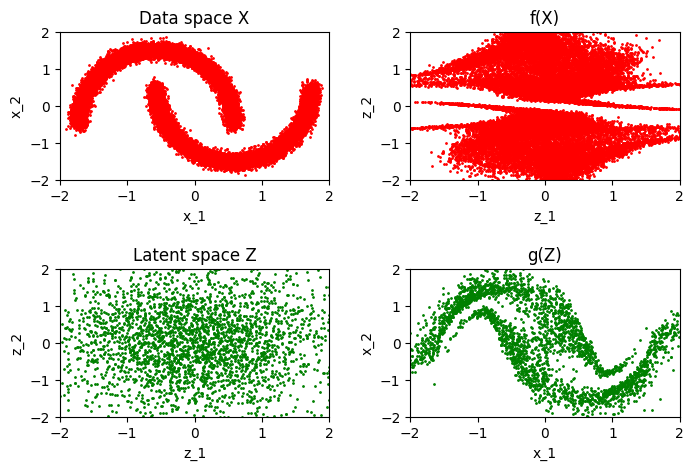

118/118 [==============================] - 1s 11ms/step - loss: 1.7102
Epoch 172/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7109
Epoch 173/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7123
Epoch 174/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7072
Epoch 175/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7116
Epoch 176/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7126
Epoch 177/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7154
Epoch 178/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7129
Epoch 179/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7220
Epoch 180/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7105
Epoch 181/300
108/118 [==========================>...] - ETA: 0s - loss: 1.7161
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

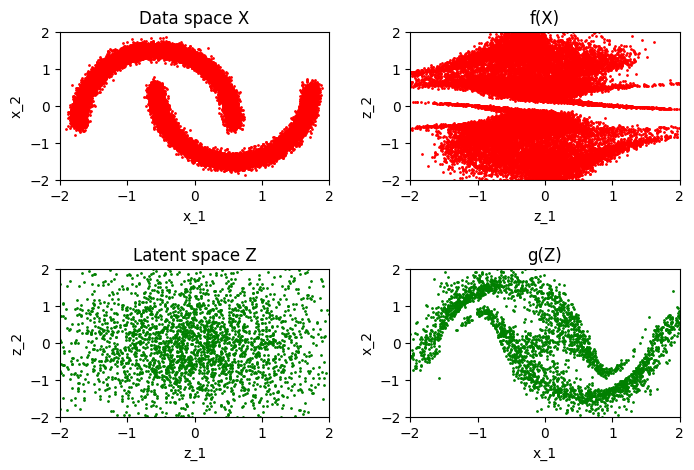

118/118 [==============================] - 1s 11ms/step - loss: 1.7150
Epoch 182/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7096
Epoch 183/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7144
Epoch 184/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7138
Epoch 185/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7105
Epoch 186/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7077
Epoch 187/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7074
Epoch 188/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7112
Epoch 189/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7085
Epoch 190/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7254
Epoch 191/300
108/118 [==========================>...] - ETA: 0s - loss: 1.7099
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

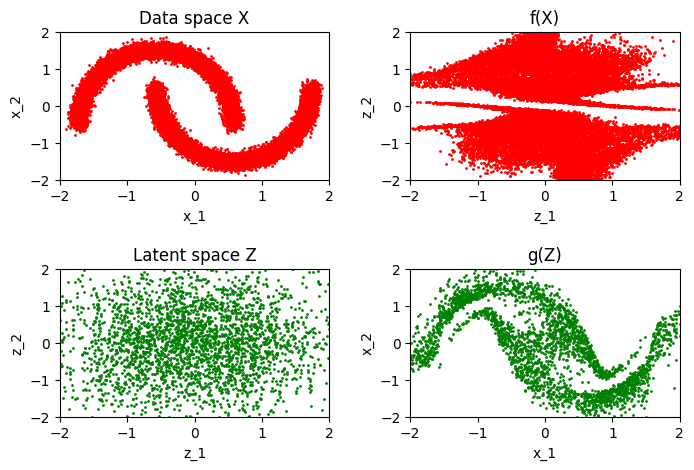

118/118 [==============================] - 1s 11ms/step - loss: 1.7091
Epoch 192/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7115
Epoch 193/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7115
Epoch 194/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7087
Epoch 195/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7089
Epoch 196/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7138
Epoch 197/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7128
Epoch 198/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7123
Epoch 199/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7104
Epoch 200/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7077
Epoch 201/300
117/118 [============================>.] - ETA: 0s - loss: 1.7070
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

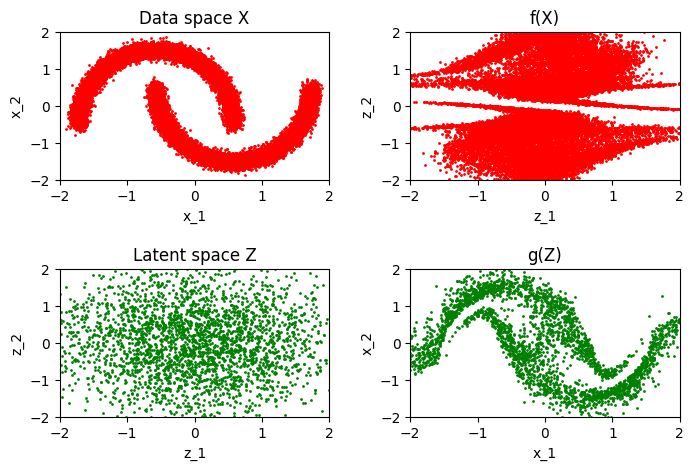

118/118 [==============================] - 1s 11ms/step - loss: 1.7071
Epoch 202/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7180
Epoch 203/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7117
Epoch 204/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7104
Epoch 205/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7117
Epoch 206/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7106
Epoch 207/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7087
Epoch 208/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7147
Epoch 209/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7125
Epoch 210/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7121
Epoch 211/300
117/118 [============================>.] - ETA: 0s - loss: 1.7101
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

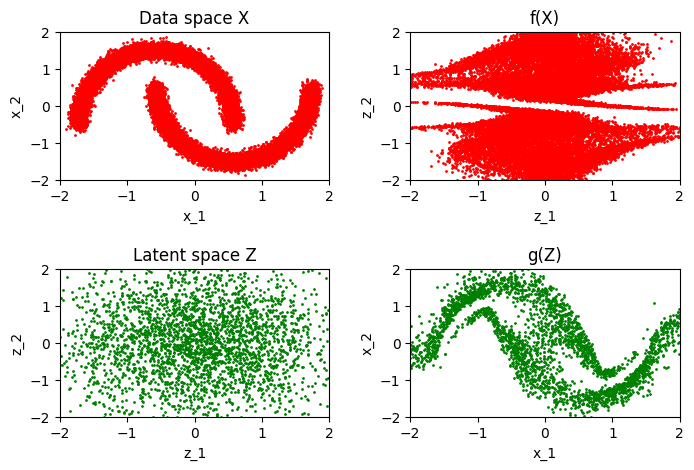

118/118 [==============================] - 1s 11ms/step - loss: 1.7094
Epoch 212/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7047
Epoch 213/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7115
Epoch 214/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7075
Epoch 215/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7066
Epoch 216/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7063
Epoch 217/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7278
Epoch 218/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7097
Epoch 219/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7106
Epoch 220/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7106
Epoch 221/300
109/118 [==========================>...] - ETA: 0s - loss: 1.7102
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

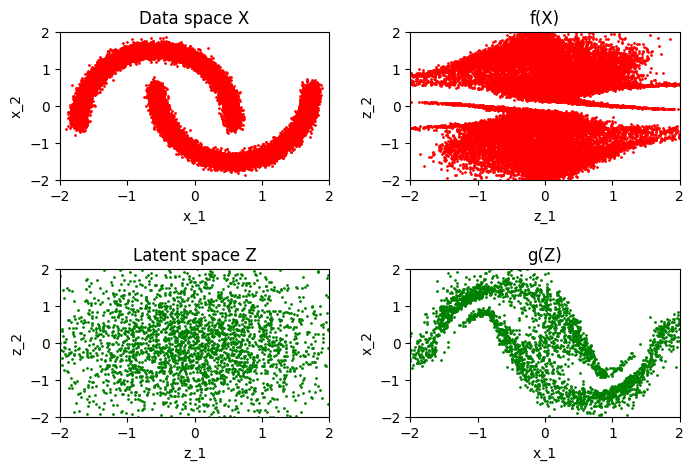

118/118 [==============================] - 1s 11ms/step - loss: 1.7077
Epoch 222/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7076
Epoch 223/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7072
Epoch 224/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7104
Epoch 225/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7083
Epoch 226/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7164
Epoch 227/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7132
Epoch 228/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7082
Epoch 229/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7149
Epoch 230/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7109
Epoch 231/300
114/118 [===========================>..] - ETA: 0s - loss: 1.7082
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

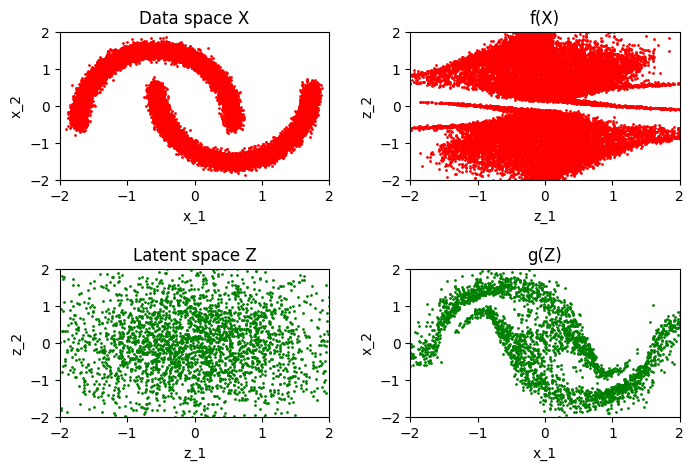

118/118 [==============================] - 1s 11ms/step - loss: 1.7074
Epoch 232/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7098
Epoch 233/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7105
Epoch 234/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7067
Epoch 235/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7084
Epoch 236/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7072
Epoch 237/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7072
Epoch 238/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7046
Epoch 239/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7083
Epoch 240/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7113
Epoch 241/300
118/118 [==============================] - ETA: 0s - loss: 1.7111
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

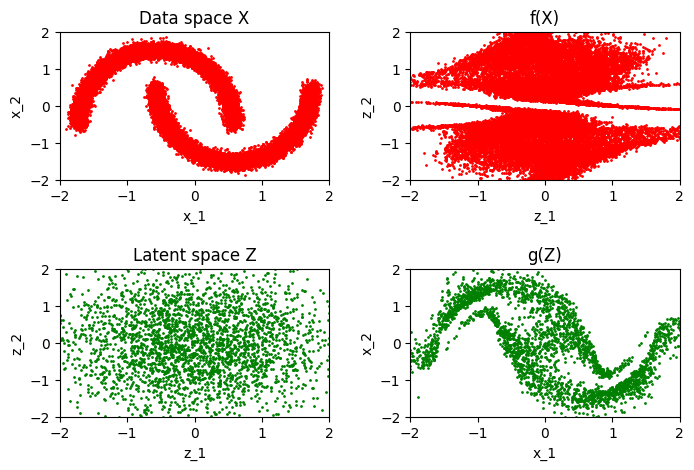

118/118 [==============================] - 1s 11ms/step - loss: 1.7111
Epoch 242/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7120
Epoch 243/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7116
Epoch 244/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7416
Epoch 245/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7095
Epoch 246/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7064
Epoch 247/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7054
Epoch 248/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7096
Epoch 249/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7068
Epoch 250/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7057
Epoch 251/300
117/118 [============================>.] - ETA: 0s - loss: 1.7069
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

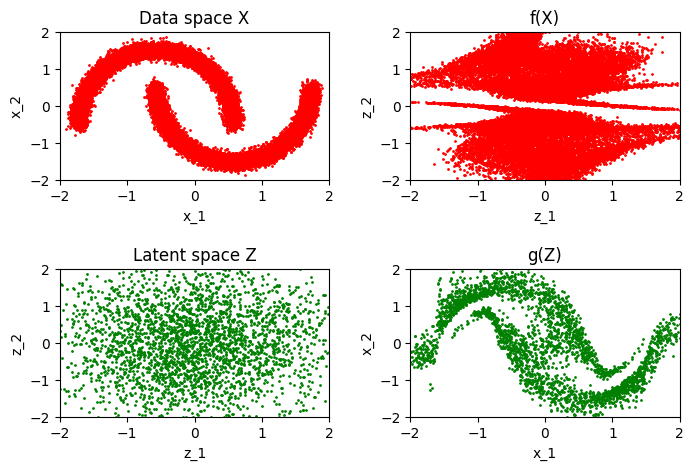

118/118 [==============================] - 1s 11ms/step - loss: 1.7077
Epoch 252/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7084
Epoch 253/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7073
Epoch 254/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7092
Epoch 255/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7083
Epoch 256/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7062
Epoch 257/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7068
Epoch 258/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7078
Epoch 259/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7091
Epoch 260/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7063
Epoch 261/300
117/118 [============================>.] - ETA: 0s - loss: 1.7158
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

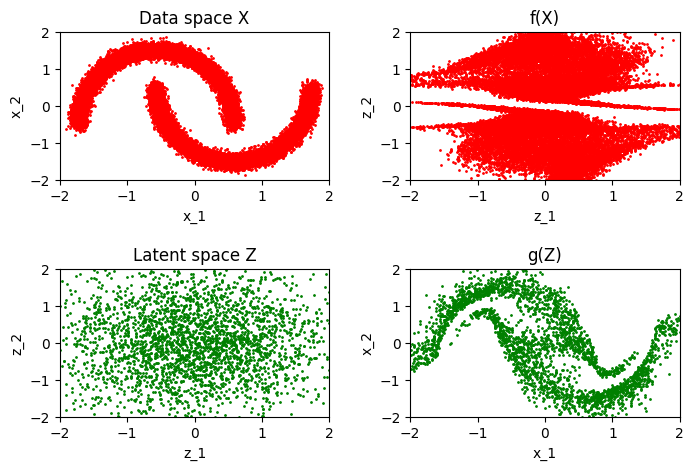

118/118 [==============================] - 2s 14ms/step - loss: 1.7150
Epoch 262/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7043
Epoch 263/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7106
Epoch 264/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7059
Epoch 265/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7133
Epoch 266/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7208
Epoch 267/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7049
Epoch 268/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7078
Epoch 269/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7088
Epoch 270/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7085
Epoch 271/300
114/118 [===========================>..] - ETA: 0s - loss: 1.7034
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

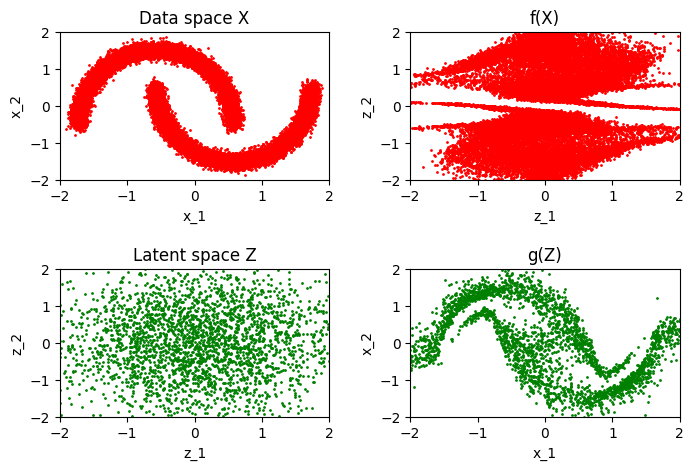

118/118 [==============================] - 1s 11ms/step - loss: 1.7029
Epoch 272/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7095
Epoch 273/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7059
Epoch 274/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7119
Epoch 275/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7158
Epoch 276/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7087
Epoch 277/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7072
Epoch 278/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7074
Epoch 279/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7060
Epoch 280/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7055
Epoch 281/300
117/118 [============================>.] - ETA: 0s - loss: 1.7194
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

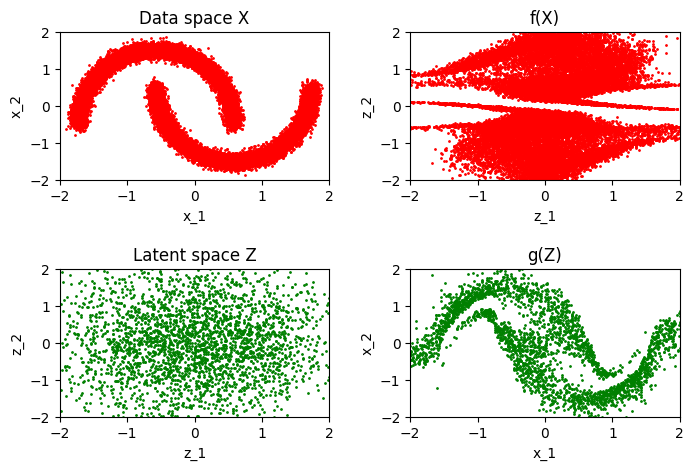

118/118 [==============================] - 1s 11ms/step - loss: 1.7184
Epoch 282/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7078
Epoch 283/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7121
Epoch 284/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7053
Epoch 285/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7046
Epoch 286/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7063
Epoch 287/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7066
Epoch 288/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7048
Epoch 289/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7051
Epoch 290/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7049
Epoch 291/300
112/118 [===========================>..] - ETA: 0s - loss: 1.7069
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/06_

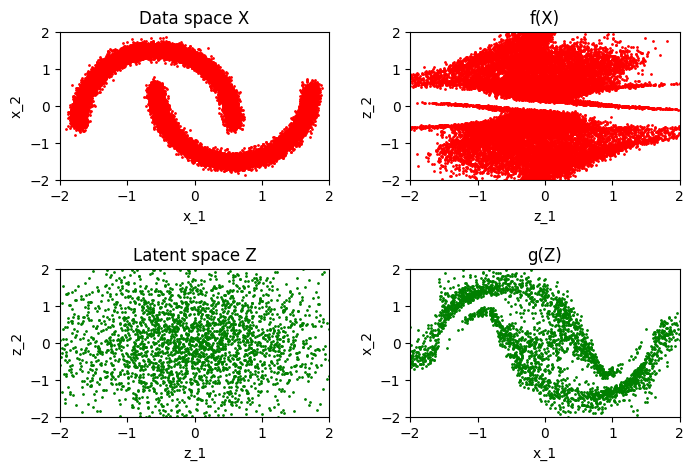

118/118 [==============================] - 1s 11ms/step - loss: 1.7064
Epoch 292/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7098
Epoch 293/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7111
Epoch 294/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7067
Epoch 295/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7037
Epoch 296/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7081
Epoch 297/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7086
Epoch 298/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7085
Epoch 299/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7095
Epoch 300/300
118/118 [==============================] - 1s 5ms/step - loss: 1.7066


In [29]:
model.fit(
    normalized_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

## 4. Generate images <a name="generate"></a>

In [30]:
x, z, samples = img_generator_callback.generate()

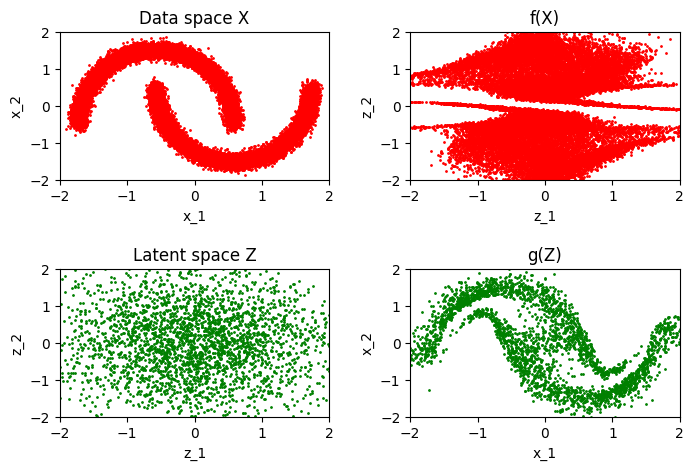

In [31]:
img_generator_callback.display(x, z, samples)